# EDA GRAMMYS DATASET


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector
import csv
import json
from prettytable import PrettyTable
import random
import numpy as np

In [35]:
# Uploading data to mysql: 

csv_file = "data/the_grammy_awards.csv"
df = pd.read_csv(csv_file)


In [83]:
df.head()

,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
0,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",https://www.grammy.com/sites/com/files/styles/...,True
1,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",https://www.grammy.com/sites/com/files/styles/...,True
2,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",https://www.grammy.com/sites/com/files/styles/...,True
3,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",https://www.grammy.com/sites/com/files/styles/...,True
4,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",https://www.grammy.com/sites/com/files/styles/...,True


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4810 entries, 0 to 4809
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          4810 non-null   int64 
 1   title         4810 non-null   object
 2   published_at  4810 non-null   object
 3   updated_at    4810 non-null   object
 4   category      4810 non-null   object
 5   nominee       4804 non-null   object
 6   artist        2970 non-null   object
 7   workers       2620 non-null   object
 8   img           3443 non-null   object
 9   winner        4810 non-null   bool  
dtypes: bool(1), int64(1), object(8)
memory usage: 343.0+ KB


In [40]:
with open('config_db.json') as config_json:
    config = json.load(config_json)

conx = mysql.connector.connect(**config) 

In [33]:
mycursor = conx.cursor()

mycursor.execute("CREATE TABLE IF NOT EXISTS grammys (id INT AUTO_INCREMENT PRIMARY KEY, year INT, title VARCHAR(1000), published_at DATETIME, updated_at DATETIME, category VARCHAR(1000), nominee VARCHAR(1000), artist VARCHAR(1000), workers VARCHAR(1000), img VARCHAR(1000), winner BOOLEAN)")

query = "DESCRIBE grammys"
mycursor.execute(query)

description_table = mycursor.fetchall()

mycursor.close()

# we have seen the creation of the table 
desc_table=pd.DataFrame(description_table, columns=['Field', 'Type', 'Null', 'Key', 'Default', 'Extra'])
print(desc_table)

mycursor.close()

           Field              Type Null  Key Default           Extra
0             id            b'int'   NO  PRI    None  auto_increment
1           year            b'int'  YES         None                
2          title  b'varchar(1000)'  YES         None                
3   published_at       b'datetime'  YES         None                
4     updated_at       b'datetime'  YES         None                
5       category  b'varchar(1000)'  YES         None                
6        nominee  b'varchar(1000)'  YES         None                
7         artist  b'varchar(1000)'  YES         None                
8        workers  b'varchar(1000)'  YES         None                
9            img  b'varchar(1000)'  YES         None                
10        winner     b'tinyint(1)'  YES         None                


False

In [87]:
"""mycursor = conx.cursor()

query = "DROP table grammys"
mycursor.execute(query)

mycursor.close()"""

True

In [36]:
mycursor = conx.cursor()

for index, row in df.iterrows():
    
    values = [row['year'], row['title'], row['published_at'], row['updated_at'], row['category'], row['nominee'], row['artist'], row['workers'], row['img'], row['winner']]
    values = [None if pd.isna(value) else value for value in values]
    
    query = "INSERT INTO grammys (year, title, published_at, updated_at, category, nominee, artist, workers, img, winner) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    
    mycursor.execute(query, values)

conx.commit()

conx.close()

### The next step is to analyze what's in this table, from null values:

In [41]:
mycursor = conx.cursor()

all_info = "SELECT * from grammys"
mycursor.execute(all_info)

results = mycursor.fetchall()

mycursor.close()

df1 = pd.DataFrame(results, columns=['id', 'year', 'title', 'published_at', 'updated_at', 'category', 'nominee', 'artist', 'workers', 'img', 'winner'])



In [ ]:
df1.shape

(4810, 11)

In [ ]:
df1.isnull().sum()

id                 0
year               0
title              0
published_at       0
updated_at         0
category           0
nominee            6
artist          1840
workers         2190
img             1367
winner             0
dtype: int64

#### There are 4810 row in the date, where 1840 are null in the artist column, 2190 in the workers column and 1367 in the img column. These are the columns with most null values. As the column img is a link, and in this analysis would not be useful later on will be deleted, but the real challenge here is the null values in artist and workers. Let's check these two columns that seems to be related:

In [ ]:
filtered_df = df1[(df1['artist'].isnull()) & (~df1['workers'].isnull())]


count = len(filtered_df)

selected_columns = filtered_df[['id', 'artist', 'workers']]

pt= PrettyTable()

pt.field_names = ['ID', 'Artist', 'Workers']

pt.align['Workers'] = 'l'

for index, row in selected_columns.iterrows():
    pt.add_row([row['id'], row['artist'], row['workers']])


print(pt)

print(f"Amount of rows: {count}")

+------+--------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|  ID  | Artist | Workers                                                                                                                                                                                                                                                             

#### As we can see there is the opportunity to take information from the workers to fill the null values of artist for 1654 rows maximum. Let's see in the workers information if the artist name is in it:

In [ ]:
df1['workers'] = df1['workers'].str.strip()

filtered_parenthesis = df1[(df1['artist'].isnull()) & df1['workers'].notna() & df1['workers'].str.endswith(')')]


selected_columns = filtered_parenthesis[['id', 'artist', 'workers']]

pt.field_names = ['ID', 'Artist', 'Workers']

pt.align['Workers'] = 'l'

print(pt)

count = len(filtered_parenthesis)

print(count)

+------+--------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|  ID  | Artist | Workers                                                                                                                                                                                                                                                             

#### this is the first case, where the artist name is inside the last parenthesis seen in the workers information. In most cases is the singer, or the composer. We can take this as the principal worker in the song, or the relevant for the press, so we can do the fill of 1334 null values with this condition, let's see if we can do more filling:

In [ ]:
filtered1= df1[df1['artist'].isnull() & df1['workers'].notna()]

# Filtra nuevamente para eliminar las filas donde 'workers' termina en ")"
filtered_not_parenthesis = filtered1[~filtered1['workers'].str.endswith(')')]

selected_columns = filtered_not_parenthesis[['id', 'artist', 'workers']]

pt = PrettyTable()


pt.field_names = ['ID', 'Artist', 'Workers']


pt.align['Workers'] = 'l'


for index, row in selected_columns.iterrows():
    pt.add_row([row['id'], row['artist'], row['workers']])


print(pt)
count = len(filtered_not_parenthesis)
print(count)

+------+--------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|  ID  | Artist | Workers                                                                                                                                                                                                                                         |
+------+--------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| 163  |  None  | Randy Brecker, soloist                                                                                                                                                                                    

#### For the rest of the 320 rows we can take the first name that is in the value workers. After research in most cases that is the principal artist, and in others there is only one name as the composer or the director. 

#### We are going to leave this transformations to the process in Airflow. 

### The next step is to analyze the unique values:

In [ ]:
df1.nunique()

id              4810
year              62
title             62
published_at       4
updated_at        10
category         638
nominee         4131
artist          1658
workers         2366
img             1463
winner             1
dtype: int64

In [ ]:
print(df1["published_at"].unique())

<DatetimeArray>
['2020-05-19 07:10:28', '2018-12-07 02:48:49', '2018-05-22 05:08:24',
 '2017-11-28 03:03:45']
Length: 4, dtype: datetime64[ns]


In [ ]:
print(df1["updated_at"].unique())

<DatetimeArray>
['2020-05-19 07:10:28', '2019-09-10 03:06:11', '2019-09-10 03:09:02',
 '2020-09-01 14:16:40', '2019-09-10 03:06:59', '2019-09-10 03:07:37',
 '2019-09-10 03:08:19', '2019-09-10 03:11:09', '2017-11-28 03:03:45',
 '2019-09-10 03:11:48']
Length: 10, dtype: datetime64[ns]


#### In the columns updated_at and published_at there are dates that does not relate with the information of the awards, it seems to be the dates where the data was published in the kaggle dataset as the year does not coincide with the year of the Grammy Awards for that song. And, as you can see there are only 4 unique values for published_at and 10 for updated_at for the whole dataset. My conclusion is that those dates are from the author's updates and uploads of the dataset, so later on will be deleted from the table. 

#### Let's see if there are no duplicated values in the nominees, using the grammys title, nominee and category (there are none or minimum nulls in this columns, that´s why we are not using artist):

In [ ]:
duplicates = df1[df1.duplicated(subset=['title', 'nominee', 'category'], keep=False)]


print("Filas duplicadas:")
print(duplicates)

Filas duplicadas:
Empty DataFrame
Columns: [id, year, title, published_at, updated_at, category, nominee, artist, workers, img, winner]
Index: []


#### We can confirm that there are no duplicated values for the nominees of the Grammys Awards. 

#### Also, for the column winner there is just one unique value which is the value "TRUE". In this analysis we are not going to consider all of them as winners but as nominees as we don't exactly know which ones are officially winners. We can confirm this with this graphic:

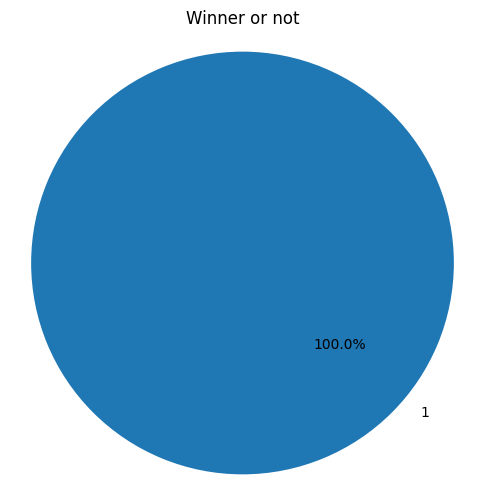

In [51]:
winner_counts = df1['winner'].value_counts()


plt.figure(figsize=(6, 6))
plt.pie(winner_counts, labels=winner_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Winner or not')
plt.axis('equal')  


plt.show()

title
62nd Annual GRAMMY Awards  (2019)    433
50th Annual GRAMMY Awards  (2007)    111
51st Annual GRAMMY Awards  (2008)    111
49th Annual GRAMMY Awards  (2006)    110
53rd Annual GRAMMY Awards  (2010)    109
52nd Annual GRAMMY Awards  (2009)    109
48th Annual GRAMMY Awards  (2005)    108
47th Annual GRAMMY Awards  (2004)    107
46th Annual GRAMMY Awards  (2003)    105
45th Annual GRAMMY Awards  (2002)    104
Name: count, dtype: int64


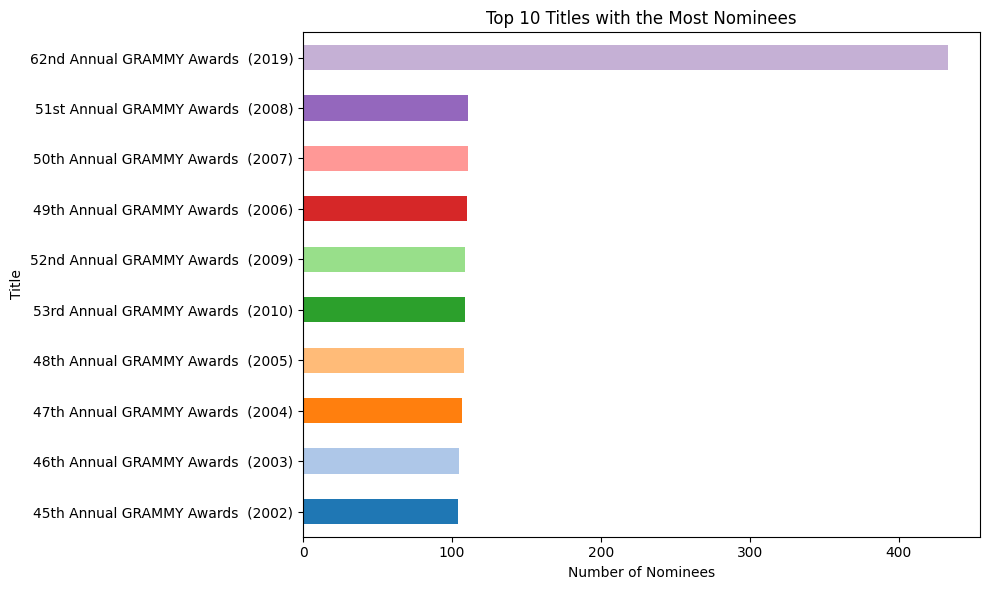

In [58]:
nominees_per_title = df1['title'].value_counts()

print(nominees_per_title.head(10))

top_10_titles = nominees_per_title.head(10)


plt.figure(figsize=(10, 6))
top_10_titles.sort_values(ascending=True).plot(kind='barh', color=color)


plt.xlabel('Number of Nominees')
plt.ylabel('Title')
plt.title('Top 10 Titles with the Most Nominees')


plt.tight_layout()
plt.show()

#### There is a lot more of information about the 62nd Annual Grammy Awards of 2019, than the other years. We have to take into account this for analysis that involve time.

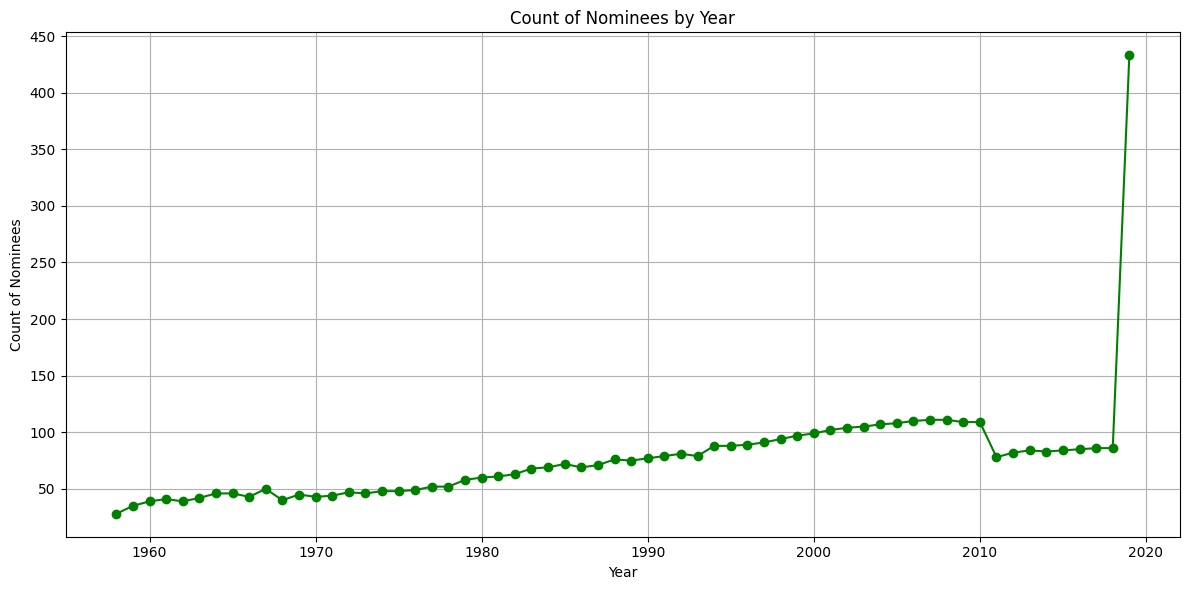

In [50]:
nominees_by_year = df1.groupby('year')['nominee'].count()


plt.figure(figsize=(12, 6))
plt.plot(nominees_by_year.index, nominees_by_year.values, marker='o', linestyle='-', color='g')


plt.xlabel('Year')
plt.ylabel('Count of Nominees')
plt.title('Count of Nominees by Year')


plt.grid(True)  
plt.tight_layout()
plt.show()

#### With this we can confirm that the year 2019 has an atypical amount of nominees, this could be because there is more information about this year or there were implemented more categories in this year, we can check the amount of categories per year:

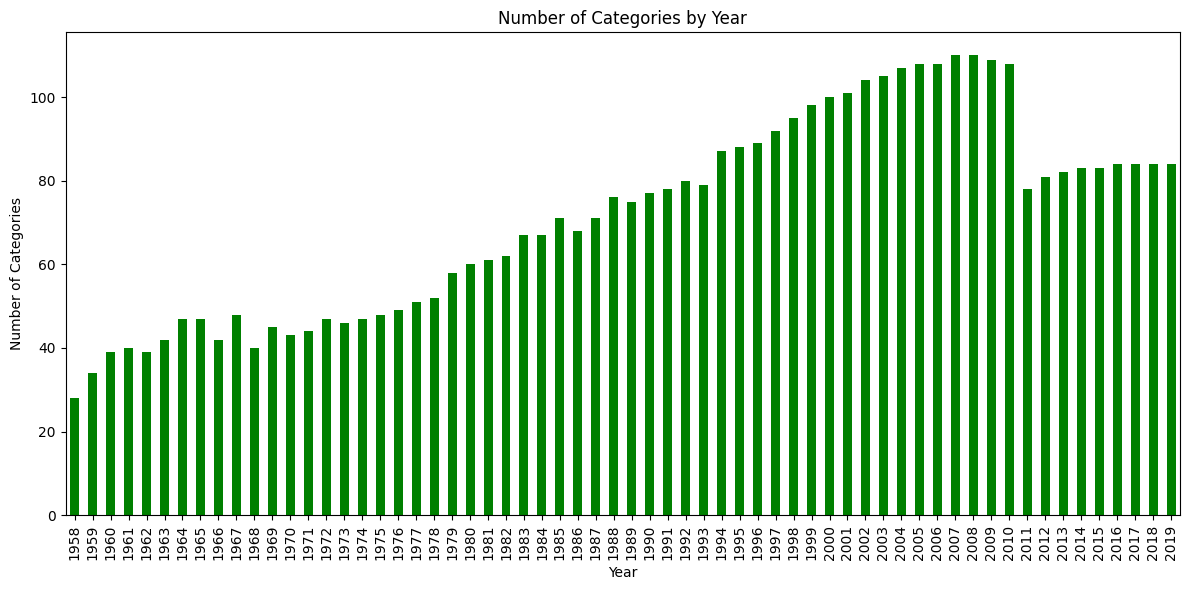

In [60]:
categories_by_year = df1.groupby('year')['category'].nunique()


plt.figure(figsize=(12, 6))
categories_by_year.plot(kind='bar', color="green")


plt.xlabel('Year')
plt.ylabel('Number of Categories')
plt.title('Number of Categories by Year')

# Show the chart
plt.tight_layout()
plt.show()

#### The number of categories does not influence the amount of nominees that 2019 has, in conclusion it is the year with more participation.

# EDA SPOTIFY DATASET:


In [4]:
csv = "data/spotify_dataset.csv"
df_spotify = pd.read_csv(csv)

### Looking at the null values:

In [4]:
df_spotify.shape

(114000, 21)

In [5]:
df_spotify.isnull().sum()

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

#### We are going to drop the first column "Unnamed":

In [5]:
df_spotify = df_spotify.drop("Unnamed: 0", axis=1)

#### This data has a different case from the grammys dataset, there is just 1 null value in the columns artist, album_name and track name, and later on we can delete them. 

#### We are going to confirm if there are repeated rows:


### Looking at the unique values:

In [14]:
df_spotify.nunique()

track_id            89741
artists             31437
album_name          46589
track_name          73608
popularity            101
duration_ms         50697
explicit                2
danceability         1174
energy               2083
key                    12
loudness            19480
mode                    2
speechiness          1489
acousticness         5061
instrumentalness     5346
liveness             1722
valence              1790
tempo               45653
time_signature          5
track_genre           114
dtype: int64

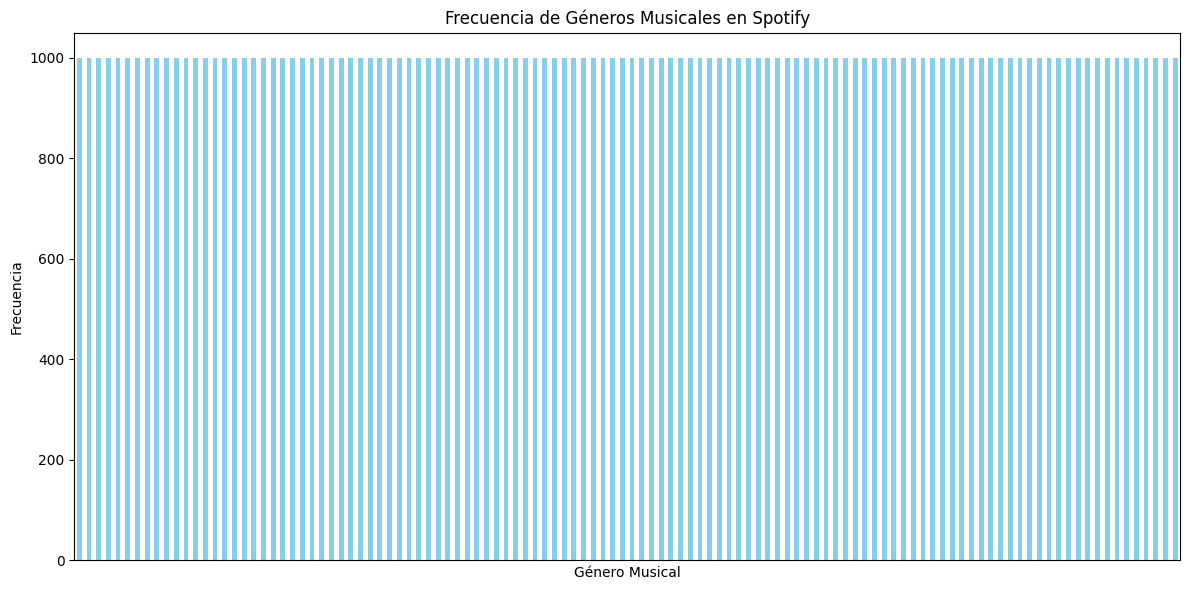

In [23]:
genre_counts = df_spotify['track_genre'].value_counts()

# Ordena los valores por frecuencia de mayor a menor
genre_popularity = genre_counts.sort_values(ascending=False)

genre_popularity = genre_counts.sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))  # Tamaño del gráfico
genre_popularity.plot(kind='bar', color='skyblue')  # Crear el gráfico de barras

# Configurar etiquetas y título
plt.xlabel('Género Musical')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Géneros Musicales en Spotify')

# Mostrar el gráfico
plt.xticks([]) # Rotar etiquetas del eje x para mejor legibilidad
plt.tight_layout()  # Ajustar diseño
plt.show()

#### We can confirm that the frequency of each track genre is the same: 1000.

In [17]:
grouped_df = df_spotify.groupby(['track_id']).size().reset_index(name='count')
grouped_df.sort_values(by = 'count', ascending= False)

,track_id,count
74276,6S3JlDAGk3uu3NtZbPnuhS,9
31724,2kkvB3RNRzwjFdGhaUA0tz,8
25740,2Ey6v4Sekh3Z0RUSISRosD,8
49042,4GPQDyw9hC1DiZVh0ouDVL,7
69228,61202Zzk9rk4bPMZLh2gr6,7
...,...,...
32929,2rHfLANXNn5ppnW0jqv8h2,1
32928,2rHX2oJ6sy9knGTBge4A3E,1
32927,2rHJDOPLTw7w5NqrTg3iBb,1
32926,2rHEyeBDE2w9jOMpTV1ICj,1


In [15]:
track_id_counts = df_spotify['track_id'].value_counts()

track_id_mas_repetido = track_id_counts.idxmax()
num_repeticiones_max = track_id_counts.max()


print(f"The most repeated track_id is {track_id_mas_repetido} with {num_repeticiones_max} repetitions.")


filas_track_id_mas_repetido = df_spotify[df_spotify['track_id'] == track_id_mas_repetido]

filas_track_id_mas_repetido

The most repeated track_id is 6S3JlDAGk3uu3NtZbPnuhS with 9 repetitions.


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
8315,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,11,-7.788,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,blues
19759,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,11,-7.788,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,country
34728,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,11,-7.788,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,folk
62226,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,11,-7.788,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,j-pop
63087,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,11,-7.788,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,j-rock
82064,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,11,-7.788,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,power-pop
84129,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,11,-7.788,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,psych-rock
99727,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,11,-7.788,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,singer-songwriter
102732,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,11,-7.788,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,songwriter


#### We can see that what's different is the genre, that´s why we are going to delete the duplicated values randomly, as there is no difference in the frequency of the genres (each of them is 1000 times in the dataset).

In [6]:
unique_spotify = df_spotify.groupby('track_id').apply(lambda group: group.sample(n=1, random_state=random.seed())).reset_index(drop=True)

unique_spotify

unique_spotify.to_csv('data/unique_spotify.csv')

#### Now, let's see if there are songs with the same album and artist:

In [7]:
unique_spotify['track_name'] = unique_spotify['track_name'].str.lower()
df_grouped = unique_spotify.groupby(['track_name', 'artists']).size().reset_index(name='count')
df_grouped.sort_values(by = 'count', ascending= False)

,track_name,artists,count
55898,rockin' around the christmas tree,Brenda Lee,45
38577,little saint nick - 1991 remix,The Beach Boys,41
56404,run rudolph run,Chuck Berry,40
24351,frosty the snowman,Ella Fitzgerald,34
37649,let it snow! let it snow! let it snow!,Dean Martin,32
...,...,...,...
27820,headlights (feat. kiddo),Alok;Alan Walker;KIDDO,1
27818,headlights,Charlie Cunningham,1
27817,headless,Cannibal Corpse,1
27816,heading south,Zach Bryan,1


In [34]:
artist_name = "The Beach Boys"
track_name = "little saint nick - 1991 remix"

# Filtra las filas que coincidan con el artista y nombre de la canción específicos
filtered_rows = df_spotify.loc[(df_spotify['artists'] == artist_name) & (df_spotify['track_name'] == track_name)]

filtered_rows.head(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
84009,1zj4qCcAbMer2WEYD27Rp2,The Beach Boys,Rock Christmas 2022 - The Very Best Of,little saint nick - 1991 remix,0,118840,False,0.602,0.553,11,-9.336,1,0.0328,0.108,0.0,0.0512,0.971,130.594,4,psych-rock
84012,0T7nrhCiwprZ2idgYz60Pi,The Beach Boys,Holiday Tunes 2022,little saint nick - 1991 remix,0,118840,False,0.602,0.553,11,-9.336,1,0.0328,0.108,0.0,0.0512,0.971,130.594,4,psych-rock
84015,58UIOx8XLh8yejsuB1sBLi,The Beach Boys,Holiday Favorites 2022,little saint nick - 1991 remix,0,118840,False,0.602,0.553,11,-9.336,1,0.0328,0.108,0.0,0.0512,0.971,130.594,4,psych-rock
84016,5OAraWHh2ZW66KHfV5gr0C,The Beach Boys,Christmas 2022,little saint nick - 1991 remix,0,118840,False,0.602,0.553,11,-9.336,1,0.0328,0.108,0.0,0.0512,0.971,130.594,4,psych-rock
84019,3SSp8LMvyCmm0rlwpxD4LQ,The Beach Boys,pov: you hear the bells jingle,little saint nick - 1991 remix,0,118840,False,0.602,0.553,11,-9.336,1,0.0328,0.108,0.0,0.0512,0.971,130.594,4,psych-rock


#### As we can see there are some difference because of the album the song belongs, but these albums are not official. There are some such as the "pov: you hear the bells jingle" that are more like compilations created by Spotify users, we can't use this column as reference and we have to decide which song we are going to leave in the data.

#### Popularity is not a determining parameter, since being in compilations the songs would be very dispersed and would be less likely to be listened to by many users. It will depend on the popularity of an unofficial album, so we will use another parameter of the song such as valence. My analysis will focus on the sensations produced by the music and if this influences a song to be more recognized or win more awards. If the values do not differ as it is in the case of the song that can be observed, any of them will be chosen randomly.

In [16]:
songs = unique_spotify.groupby(['track_name', 'artists'])['valence'].idxmax()

final_spotify = unique_spotify.loc[songs]

final_spotify

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
7645,0fROT4kK5oTm8xO8PX6EJF,Rilès,!I'll Be Back!,!i'll be back!,52,178533,True,0.823,0.6120,1,-7.767,1,0.2480,0.1680,0.000000,0.1090,0.6880,142.959,4,french
19576,1hH0t381PIXmUVWyG1Vj3p,Brian Hyland,The Bashful Blond,"""a"" you're adorable",39,151680,False,0.615,0.3750,0,-10.362,0,0.0319,0.4820,0.000000,0.1110,0.9220,110.720,4,rockabilly
13611,1B45DvGMoFWdbAEUH2qliG,Little Apple Band,The Favorite Songs Of Sesame Street,"""c"" is for cookie",32,84305,False,0.553,0.8120,3,-5.542,1,0.0558,0.1320,0.000010,0.0794,0.8710,118.368,4,kids
8445,0jmz4aHEIBCRgrcV2xEkwB,Traditional;Sistine Chapel Choir;Massimo Palom...,Classical Christmas,"""christe, redemptor omnium""",0,289133,False,0.111,0.0568,10,-28.053,1,0.0551,0.9900,0.697000,0.1100,0.0395,169.401,1,sleep
64121,5Zx0Rrkn5RFBMD2PRxX3mI,Dillinger Four,C I V I L W A R,"""contemplate this on the tree of woe.""",24,180706,False,0.565,0.9770,11,-3.592,1,0.0546,0.0282,0.001320,0.4330,0.3870,106.478,4,power-pop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32404,2oVHb8wyg6oC2iNpGBNvx1,HEIZE,Hotel del Luna (Original Television Soundtrack...,내 맘을 볼 수 있나요,63,225785,False,0.397,0.1660,9,-10.678,1,0.0349,0.8840,0.000000,0.1000,0.1310,134.708,4,k-pop
54610,4kIpBfvK44bxqX7zo8K1oP,Gaho,ITAEWON CLASS (Original Television Soundtrack)...,시작,65,202440,False,0.591,0.8180,4,-3.532,1,0.0730,0.1720,0.000000,0.1260,0.5740,108.107,4,k-pop
54982,4mHc7LUlO3k6AXeFV2EiJK,Yiruma,Yiruma Official Album 'Piano Therapy' (The Ori...,약속 (piano solo),37,144533,False,0.504,0.1430,1,-18.713,1,0.0701,0.9800,0.922000,0.1240,0.0584,148.786,4,new-age
10201,0tQesiSZJQOdHeAC7r59us,GODA,One Punch Man (Original Soundtrack),원펀맨 theme - sad theme,37,228000,False,0.542,0.3370,2,-16.088,1,0.0539,0.9850,0.933000,0.1470,0.4430,159.951,4,piano


#### We can confirm that there are no repeated values now:

In [18]:
df_grouped = final_spotify.groupby(['track_name', 'artists']).size().reset_index(name='count')
df_grouped.sort_values(by = 'count', ascending= False)

,track_name,artists,count
0,!i'll be back!,Rilès,1
54135,rajvaadi odhni,Pritam;Jonita Gandhi,1
54142,rakovina,Zhanna Bichevskaya;Gennadiy Ponomarjov,1
54141,rakkauden satu,Reijo Taipale,1
54140,rakka,Project AER;v i v,1
...,...,...,...
27067,half the time,The Lemonheads,1
27066,half the perfect world,Madeleine Peyroux,1
27065,half smile,Sex Prisoner,1
27064,half of my heart,John Mayer,1


#### this transformations are going to be done in airflow's workflow, this whole EDA had the purpose to see which approach better fit to do the tranformations to both of the datasets. Now we can do some graphics:

### Explicit vs not explicit songs:

In [1]:
explicit_counts = final_spotify['explicit'].value_counts()

# Crear un pie chart
plt.figure(figsize=(6, 6))
plt.pie(explicit_counts, labels=explicit_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Explicit songs in Spotify')
plt.axis('equal')  # Hace que el gráfico de pastel sea un círculo perfecto
plt.show()

NameError: name 'final_spotify' is not defined

#### It can be seen that just 8.6% of the songs of this data are explicit. 

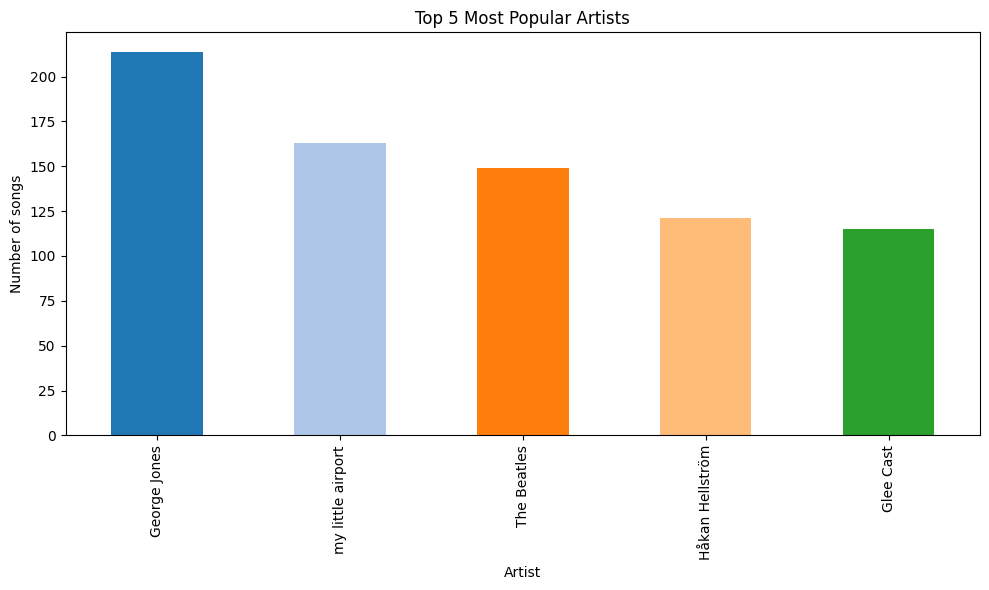

In [29]:
artist_counts = final_spotify['artists'].value_counts()

top_5_artists = artist_counts.head(5)

color= plt.cm.tab20.colors

plt.figure(figsize=(10, 6))
top_5_artists.plot(kind='bar', color=color)
plt.xlabel('Artist')
plt.ylabel('Number of songs')
plt.title('Top 5 Most Popular Artists')


plt.tight_layout()
plt.show()

#### The most popular artist is George Jones, but we can't prove that there is a unique person with that common name. So, to have a more accurate analysis we will take as the most famous artist in this dataset as My little airport for the originality of the band name. 